In [2]:
import numpy as np
import cv2
import PIL
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib nbagg

**Иницианилизируем объекты библиотеки Aruco и константы**

In [2]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters = aruco.DetectorParameters_create()
parameters.cornerRefinementMethod = aruco.CORNER_REFINE_SUBPIX
real_sqr_size = 15  # mm !задано ручками!
marks_num = 5

**Генерируем метки для задания пространства идентификаторов**
**(а также для печати)**

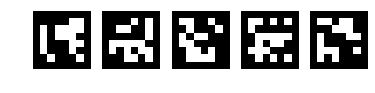

In [3]:
fig = plt.figure()
nx = 5
ny = np.ceil(marks_num / 5)
for i in range(1, marks_num + 1):
    ax = fig.add_subplot(ny, nx, i)
    img = aruco.drawMarker(aruco_dict, i, 700)
    plt.imshow(img, cmap=mpl.cm.gray, interpolation="nearest")
    ax.axis("off")

plt.savefig("_data/markers.jpg")
plt.show()

**Распознаем идентификаторы, с которыми в дальнейшем будем работать**

In [4]:
squaers_frame = cv2.imread("_data/markers.jpg")
gray_squaers_frame = cv2.cvtColor(squaers_frame, cv2.COLOR_BGR2GRAY)
_, all_ids, _ = aruco.detectMarkers(gray_squaers_frame, aruco_dict, parameters=parameters)

all_ids = all_ids[:,0]
all_ids.sort()
all_ids

array([1, 2, 3, 4, 5], dtype=int32)

In [ ]:
def coor(file_name, out_video=True):
    calibrated = True
    cap = cv2.VideoCapture(file_name)
    width, height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    if (out_video):
        # Открываем поток записи в видеофайл
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        fn, ext = file_name.rsplit('.', 1)
        out = cv2.VideoWriter("%s (Резмеченный).%s" %
                              (fn, ext), fourcc, cap.get(cv2.CAP_PROP_FPS), (width, height))
    
    

    has_square_size = False
    while(cap.isOpened()):
        cur_time = cap.get(cv2.CAP_PROP_POS_MSEC)
        ret, frame = cap.read()
        if ret:
            detected_squares, marked_frame = detect_squares(frame)
            aruco.calibrateCameraAruco()
            if out_video:
                if all(np.isnan(arr[1:])):
                    out.write(frame)
                else:
                    out.write(marked_frame)
        else:
            cap.release()
            if out_video:
                out.release()

    
    return df_report

In [5]:
def detect_squares(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
    
    #Функция выделяет на картинке найденные квадраты
    frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
    
    #Полагаем, что каждый квадрат встречается на картинке один раз,
    #если нет, то берем первое найденноевхождение в картинку
    
    if len(corners) != 0:
        corners = np.asarray(corners).swapaxes(0,1)[0]
    
        return { _id : square for _id, square in zip(ids[:,0], corners)}, frame_markers
    return {}, None

#Проверка для тестирования работы функции
#detected_squaers, frame = detect_squares(frame)

**Перерасчет координат углов квадратов в их центры**

In [6]:
def to_array(detected_squaers, cur_time):
    centers = {_id : [square[:,0].mean(), square[:,1].mean()] for _id, square in detected_squaers.items()}
    
    data_for_df = []
    for _id in all_ids:
        point = centers.get(_id)
        
        if point is None:
            data_for_df += [np.NaN, np.NaN]
        else:
            data_for_df += point

    return np.asarray([cur_time]+data_for_df)

#Проверка для тестирования работы функции
#to_array(detected_squaers)

In [7]:
def get_sqr_sizes(detected_squares):
    squares_sizes = []
    for _id, sqr in detected_squares.items():
        if _id in all_ids: #нас интересуют только сгенерированные в начале проги квадратики
            #За стороны квадрата берем самые большие прирощения по X и по Y соответственно
            dx = [abs(sqr[i,0]-sqr[i+1,0])/real_sqr_size for i in range(-1,3)]
            dy = [abs(sqr[i,1]-sqr[i+1,1])/real_sqr_size for i in range(-1,3)]
            squares_sizes.append( max(dx) )
            squares_sizes.append( max(dy) )
    return squares_sizes

**Формирование отчета в виде видео с выделением на кадрах меток**
**и файла excel с смещениями в миллиметрах для каждой метки**

In [8]:
def get_report(file_name, out_video=True, get_unnormed_df=False):
    unnormed_df = None
    cap = cv2.VideoCapture(file_name)
    width, height = int(cap.get(3)), int(cap.get(4))

    if (out_video):
        # Открываем поток записи в видеофайл
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        fn, ext = file_name.rsplit('.', 1)
        out = cv2.VideoWriter("%s (Резмеченный).%s" %
                              (fn, ext), fourcc, 20.0, (width, height))

    report = []
    time_col = []

    has_square_size = False
    while(cap.isOpened()):
        cur_time = cap.get(cv2.CAP_PROP_POS_MSEC)
        ret, frame = cap.read()
        if ret:
            detected_squares, marked_frame = detect_squares(frame)

            # Единожды вычисляем размеры каждого квадратика по OX и OY
            if not has_square_size:
                squares_sizes = get_sqr_sizes(detected_squares)
                if len(squares_sizes) == len(all_ids)*2:
                    has_square_size = True

            arr = to_array(detected_squares, cur_time)
            report.append(arr)

            if out_video:
                if all(np.isnan(arr[1:])):
                    out.write(frame)
                else:
                    out.write(marked_frame)
        else:
            cap.release()
            if out_video:
                out.release()

    report = np.asarray(report)

    # Обрезаем записи без значений (NaN) в начале и в конце массива
    # т.к. они не будут участвовать в расчетах и не несут полезной информации
    # report.
    nan_strs = [all(np.isnan(s[1:])) for s in report]
    no_nan_strs = [not any(np.isnan(s[1:])) for s in report]
    try:
        L, R = no_nan_strs.index(True), len(
            nan_strs) - nan_strs[::-1].index(False)
    except Exception as ex:
        print(file_name, " - ", ex)
        res = pd.DataFrame()
        return None, None

    report = report[L:R]

    if get_unnormed_df:
        rep = pd.DataFrame(index=report[:, 0].copy(), data=report[:, 1:].copy(
        ), columns=pd.MultiIndex.from_product([all_ids, ['X', 'Y']]))
        rep.index.name = 'Время, мс'
        rep.columns.names = ['№ метки', 'Ось']
        unnormed_df = rep

    report -= report[0]  # Берем начальное положение меток как (0,0)
    # Переводим величину смещения из пикселей в миллиметры
    report[:, 1:] /= squares_sizes

    df_report = pd.DataFrame(index=report[:, 0], data=report[:, 1:],
                             columns=pd.MultiIndex.from_product([all_ids, ['X', 'Y']]))
    df_report.index.name = 'Время, мс'
    df_report.columns.names = ['№ метки', 'Ось']

    return df_report, unnormed_df

In [41]:
% % time
color = ['white']  # ['black', 'blue', 'green', 'red', 'yellow', 'white']
file_names = ['source/%s.mp4' % s for s in color]

reports, raw_reports = [], []
for f in file_names:
    df_report, rep = get_report(f, False, True)
    if df_report is not None:
        reports.append(df_report)
    if rep is not None:
        raw_reports.append(rep)
# df_report.to_excel('report.xlsx')

Wall time: 1min 18s


**Вычисляем производные для каждой метки**

## TODO: Производные по участкам без разрывов

In [19]:
def get_clear_spans(arr, min_span_size=30):
    spans = []
    isSpan = False
    start = None
    i = 0
    while i < len(arr):
        if np.isnan(arr.iloc[i]) and isSpan:
            if i - start >= min_span_size:  # Если последовательность достаточно длинная
                spans.append((start, i))
            start = None
            isSpan = False
        elif not np.isnan(arr.iloc[i]) and not isSpan:
            isSpan = True
            start = i
        i += 1
    if start is not None and i-start >= min_span_size:
        spans.append((start, i))
    return spans

# Testing
#a = list(range(10)) + [np.NaN]*5 + list(range(5))
# print(a)
# print(list(range(len(a))))
#get_clear_spans(a, 11)

In [46]:
def add_derivative_cols(df_report):
    def series_derivative(col, min_span_size):
        spans = get_clear_spans(col, min_span_size=30)
        dx = np.empty(len(col), dtype=np.float64)

        for s in spans:
            dx[s[0]:s[1]] = np.gradient(
                col.iloc[s[0]:s[1]], col.index[s[0]:s[1]])
        return pd.Series(dx, index=col.index)

    for _id in all_ids:
        df_report[(_id, 'dX')] = series_derivative(
            df_report[(_id, 'X')], min_span_size=30)
        df_report[(_id, 'dY')] = series_derivative(
            df_report[(_id, 'Y')], min_span_size=30)

    df_report = df_report.reindex(
        sorted(df_report.columns), axis=1, copy=False)
    return df_report


for report in reports:
    add_derivative_cols(report)

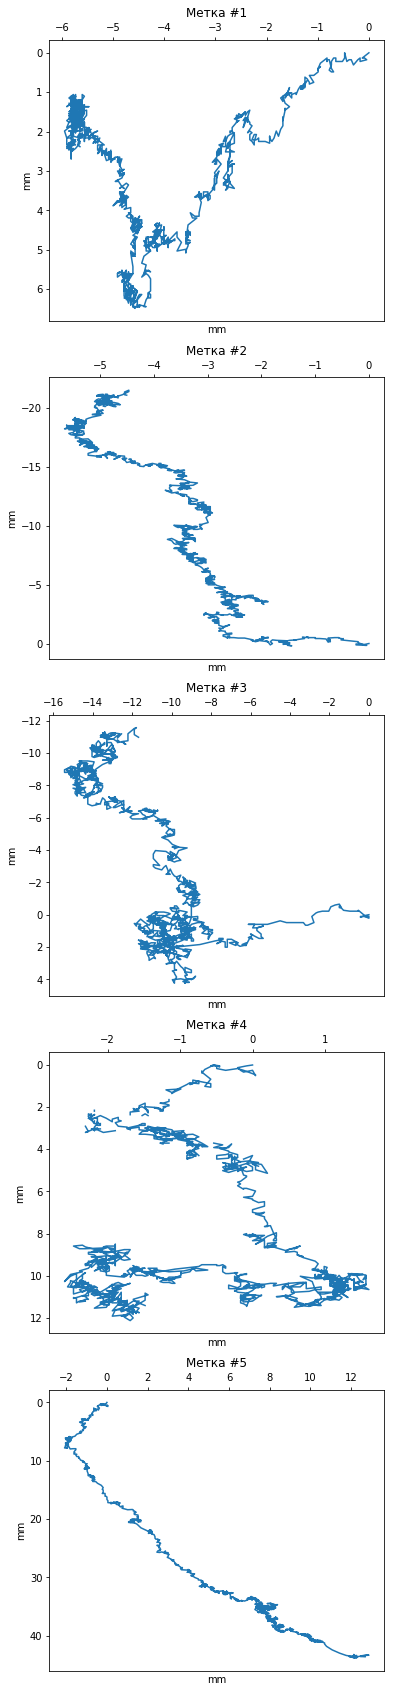

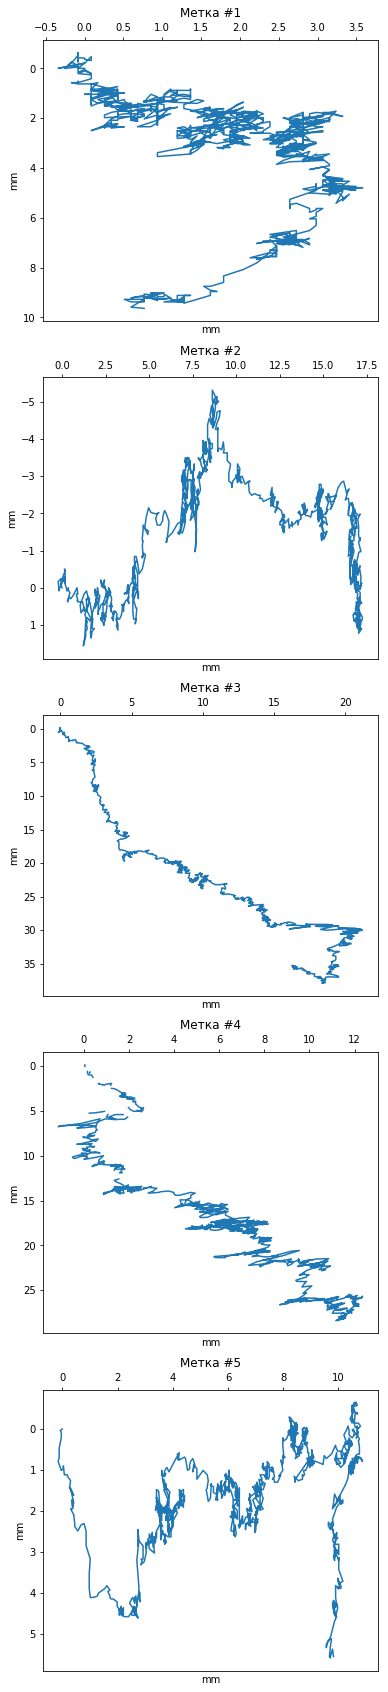

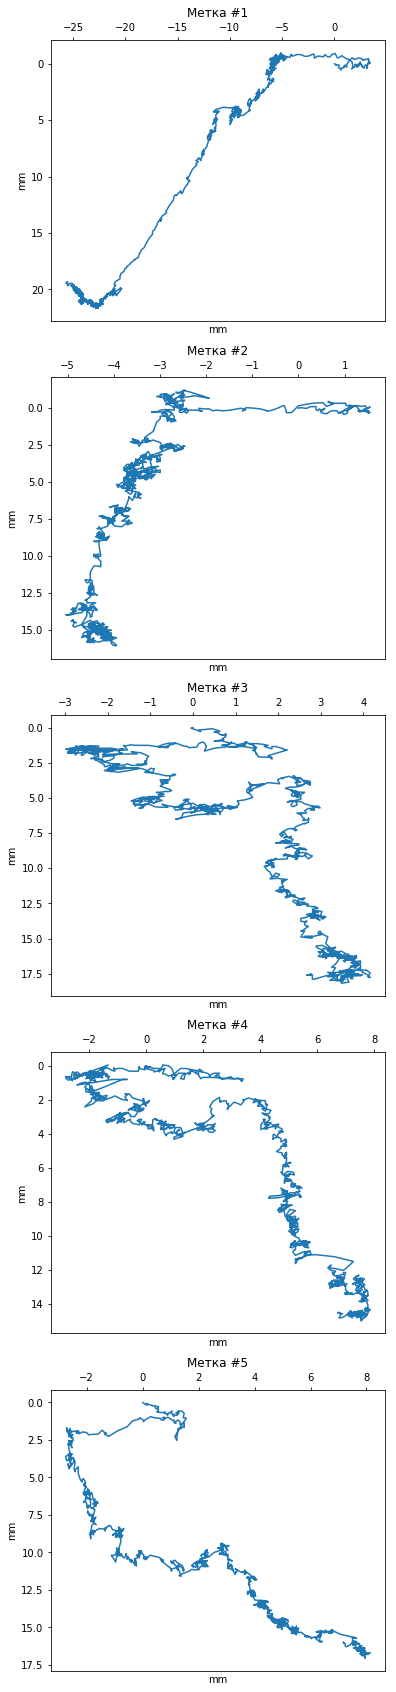

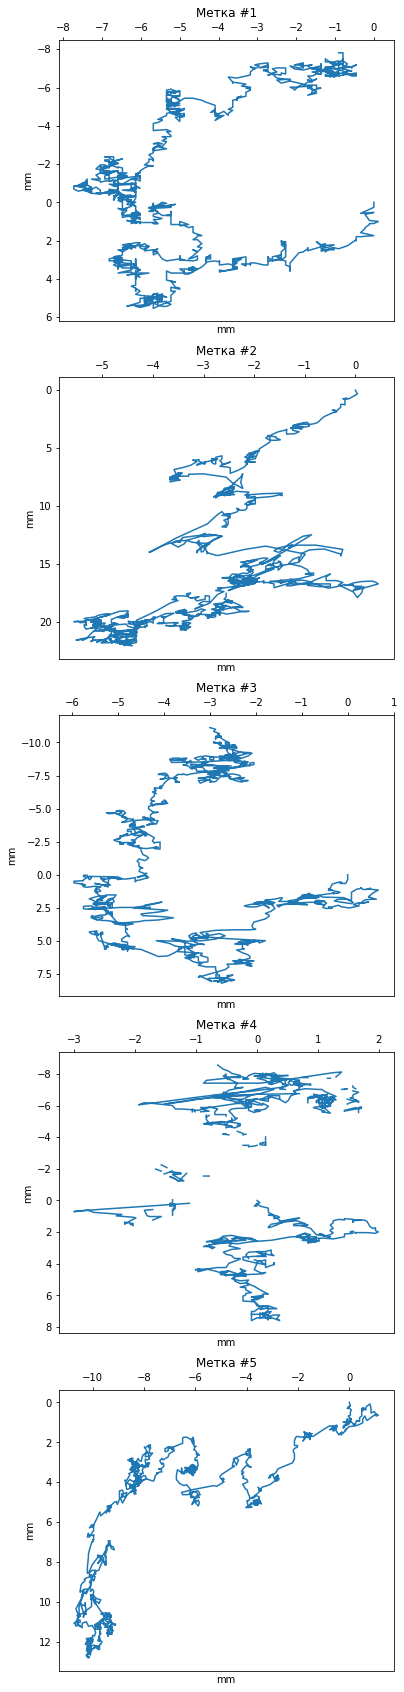

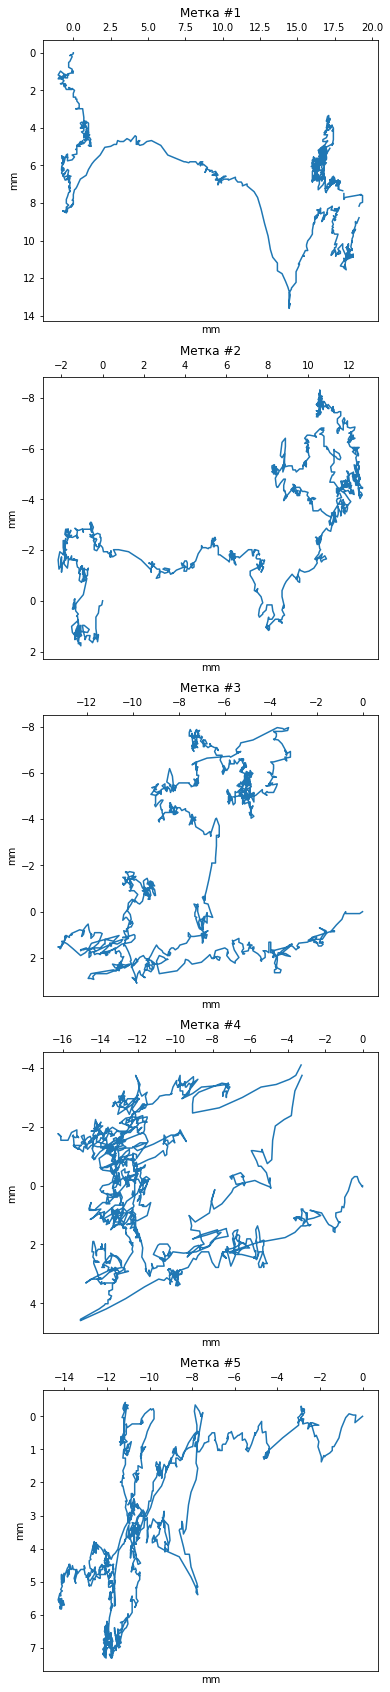

In [11]:
for num, df_report in enumerate(reports):
    if df_report.empty:
        continue

    fig, plots = plt.subplots(len(all_ids), 1, figsize=(6, len(all_ids)*6))

    for i, _id in enumerate(all_ids):
        plots[i].plot(df_report[(_id, 'X')], df_report[(_id, 'Y')])
        plots[i].title.set_text('Метка #%d' % (_id))
        plots[i].invert_yaxis()
        plots[i].xaxis.tick_top()
        plots[i].set_ylabel('mm')
        plots[i].set_xlabel('mm')
    plt.savefig('graphs/%s_раздельно.jpg' % color[num], dpi=250)

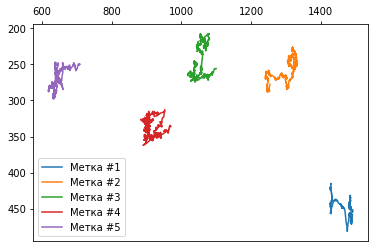

In [12]:
for num, rep in enumerate(raw_reports):
    if rep.empty:
        continue

    plt.close(fig)
    plt.cla()
    plt.clf()
    plt.gca().invert_yaxis()
    plt.gca().xaxis.tick_top()
    for i, _id in enumerate(all_ids):
        plt.plot(rep[(_id, 'X')], rep[(_id, 'Y')])
    plt.legend(["Метка #%d" % _id for _id in all_ids])
    plt.savefig('graphs/%s_совмествно.jpg' % color[num], dpi=400)

In [21]:
for i, report in enumerate(reports):
    report.to_excel('reports/%s_report.xlsx' % color[i])

In [47]:
# len(reports)
reports[0]

№ метки               1                    2                   3            \
Ось                   X         Y          X         Y         X         Y   
Время, мс                                                                    
0.000000       0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   
33.317051      0.000000  0.051370  -0.040761  0.161290 -0.122283  0.082418   
66.634102     -0.234375  0.154110  -0.122283  0.201613 -0.366848  0.082418   
99.951154     -0.156250  0.102740  -0.163043  0.201613 -0.733696  0.082418   
133.268205    -0.078125  0.205479  -0.203804  0.483871 -0.733696  0.000000   
166.585256    -0.234375  0.462329  -0.326087  0.645161 -0.815217  0.123626   
199.902307    -0.312500  0.513699  -0.326087  0.766129 -0.896739  0.329670   
233.219359    -0.312500  0.770548  -0.326087  1.088710 -1.141304  0.576923   
266.536410    -0.078125  0.873288  -0.244565  1.612903 -1.385870  0.865385   
299.853461    -0.078125  1.027397  -0.203804  1.370968 -1.222826  0.865385   
333.170512     0.000000  0.976027  -0.203804  1.330645 -1.222826  0.824176   
366.487563    -0.078125  0.976027  -0.203804  1.330645 -1.263587  0.824176   
399.804615     0.000000  1.078767  -0.285326  1.491935 -1.548913  0.906593   
433.121666    -0.156250  1.078767  -0.448370  1.491935 -2.201087  1.112637   
466.438717    -0.390625  1.130137  -0.407609  1.411290 -2.282609  1.277473   
499.755768    -0.390625  1.130137  -0.407609  1.290323 -2.160326  1.236264   
533.072820    -0.390625  1.130137  -0.326087  1.330645 -1.956522  1.359890   
566.389871    -0.312500  1.181507  -0.326087  1.451613 -2.119565  1.318681   
599.706922    -0.390625  1.181507  -0.407609  1.491935 -1.997283  1.318681   
633.023973    -0.390625  1.284247  -0.489130  1.653226 -1.915761  1.483516   
666.341024    -0.390625  1.335616  -0.489130  1.653226 -1.834239  1.483516   
699.658076    -0.546875  1.335616  -0.529891  1.612903 -1.793478  1.483516   
732.975127    -0.625000  1.232877  -0.652174  1.532258 -1.711957  1.401099   
766.292178    -0.546875  1.181507  -0.611413  1.370968 -1.834239  1.318681   
799.609229    -0.625000  1.181507  -0.611413  1.370968 -1.711957  1.318681   
832.926280    -0.703125  1.232877  -0.774457  1.370968 -1.875000  1.359890   
866.243332    -0.703125  1.335616  -0.855978  1.532258 -1.875000  1.318681   
899.560383    -0.781250  1.284247  -0.855978  1.451613 -1.793478  1.112637   
932.877434    -1.015625  1.181507  -0.937500  1.209677 -1.589674  0.824176   
966.194485    -0.859375  0.976027  -0.978261  0.967742 -1.875000  0.700549   
...                 ...       ...        ...       ...       ...       ...   
44245.044019  16.093750  6.164384  10.597826 -7.379032 -7.214674 -7.211538   
44278.361070  16.093750  6.164384  10.475543 -7.459677 -7.336957 -7.252747   
44311.678121  16.093750  6.113014  10.394022 -7.500000 -7.377717 -7.252747   
44344.995173  16.093750  6.113014  10.475543 -7.459677 -7.377717 -7.211538   
44378.312224  16.093750  6.215753  10.475543 -7.338710 -7.336957 -7.170330   
44411.629275        NaN       NaN  10.394022 -7.379032 -7.255435 -7.087912   
44444.946326  16.171875  6.267123  10.516304 -7.338710 -7.296196 -7.087912   
44478.263378        NaN       NaN  10.394022 -7.338710 -7.418478 -7.046703   
44511.580429        NaN       NaN  10.475543 -7.258065 -7.336957 -6.923077   
44544.897480        NaN       NaN  10.394022 -7.258065 -7.418478 -7.087912   
44578.214531  16.171875  6.318493  10.475543 -7.338710 -7.418478 -7.170330   
44611.531582  16.171875  6.318493  10.557065 -7.338710 -7.296196 -7.087912   
44644.848634  16.171875  6.318493  10.557065 -7.379032 -7.296196 -7.211538   
44678.165685        NaN       NaN  10.557065 -7.500000 -7.336957 -7.252747   
44711.482736  16.093750  6.164384  10.475543 -7.500000 -7.418478 -7.170330   
44744.799787        NaN       NaN  10.557065 -7.500000 -7.377717 -7.211538   
44778.116838        NaN       NaN  10.597826 -7.661290 -7.418478 -7.541209   
44811.433890        Na